In [1]:
%load_ext autoreload
%autoreload 2

import logging
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import tensor, Tensor
from typing import Any

import weight_formats.experiments as E
import weight_formats.quantisation as Q

logging.basicConfig(level=logging.WARNING, force=True)
matplotlib.rcParams.update({
    "axes.spines.top": False, "axes.spines.right": False, "legend.frameon": False,
    "figure.figsize": (5, 3),
})
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.set_default_device(DEVICE)

## Example

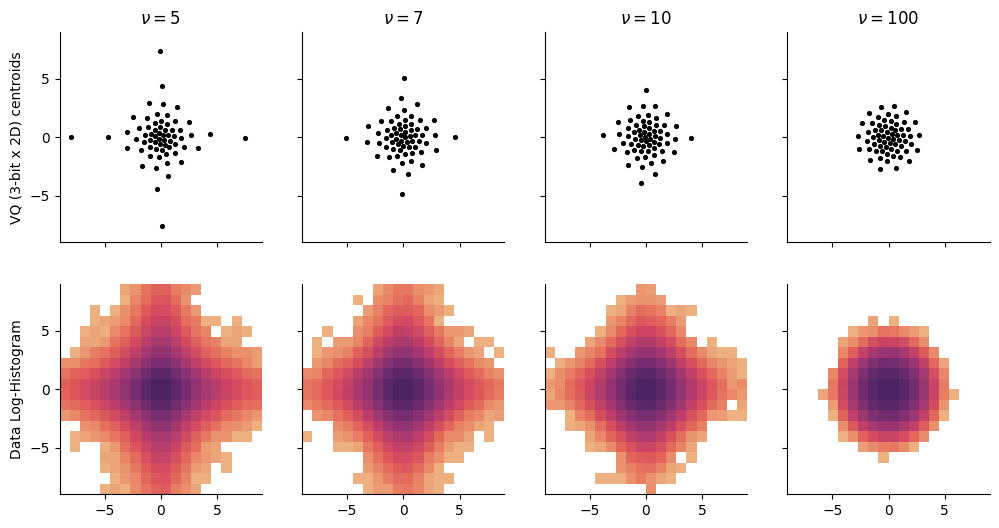

In [4]:
torch.manual_seed(100)
dfs = [5, 7, 10, 100]
_, axs = plt.subplots(2, len(dfs), figsize=(3*len(dfs), 3*2), sharex=True, sharey=True)
lim = 9
for df, axc in zip(dfs, axs.T):
    x = torch.distributions.StudentT(df, scale=((df - 2) / df) ** .5).sample((2**24,))
    fmt = Q.vlut_lloyd_max(x.view(-1, 2), 3, 10**-3, Q.BFLOAT16)
    axc[0].set_title(f"$\\nu={df}$")
    axc[0].scatter(*zip(*fmt.values), lw=0, s=14, color="k")
    axc[1].hist2d(*x.view(-1, 2).cpu().T, norm="log", bins=torch.linspace(-lim, lim, 21).cpu(), cmap="flare")
axs[0, 0].set_ylabel("VQ (3-bit x 2D) centroids")
axs[1, 0].set_ylabel("Data Log-Histogram")
axs[0, 0].set_xlim(-lim, lim)
axs[0, 0].set_ylim(-lim, lim);

In [6]:
t_df = 10
x = torch.distributions.StudentT(t_df).sample((2**20,))
ofmt = Q.LinearScalingFormat(Q.crd_t(3, t_df), Q.BFLOAT16, (None,), "rms")
sfmt = Q.lut_lloyd_max(x, 3, 10**-4)
vfmt = Q.vlut_lloyd_max(x.view(-1, 2), 3, 10**-3, Q.BFLOAT16)
vfmt4 = Q.vlut_lloyd_max(x.view(-1, 4), 3, 10**-3, Q.BFLOAT16)
cfmt = Q.CompressedLUTFormat.train_grid(x, 0.58)
print(f"{'fmt':<35}  {'b':<3}  {'R'}")
for fmt in [ofmt, sfmt, vfmt, vfmt4, cfmt]:
    print(f"{str(fmt):<35}  {fmt.count_bits_tensor(x) / x.nelement():.1f}  {Q.qrmse_norm(fmt, x):.3f}")

fmt                                  b    R
LUT3[CRD-T[10]-RS]{*:BFLOAT16:rms}   3.0  0.213
LUT3[LM]                             3.0  0.224
VLUT3x2[LM]                          3.0  0.185
VLUT3x4[LM]                          3.2  0.160
LUT6[GRID{0.58}]+Zoptimal            3.0  0.150


## Results

In [116]:
runs = E.runs("20250729-results-additional")

def fmt_name(fmt: E.AttrDict) -> str:
    s = [{(None, None): "Tensor", (1, None): "Channel"}.get(tuple(fmt.block_shape), "Block") + f" {fmt.scaling.capitalize()}"]
    if fmt.compressor:
        s.append("Compression")
    if fmt.sparse_ratio:
        s.append("Sparse")
    return " + ".join(s).replace("Rms", "RMS")

df = pd.DataFrame.from_records([dict(
    # id=run.id,
    model=run.config.model.split("/")[-1],
    fmt=run.config.test.fmt_str.replace(":BFLOAT16", "").replace(":search", "").replace("(mode=asymmetric)", ""),
    scaling=fmt_name(fmt),
    element_family=fmt.element_family,
    vq_length=fmt.vq_length,
    rotation=bool(fmt.rotation),
    bits_per_param=run.summary.bits_per_param,
    # duration=run.meta.duration,
    kl_div=tensor(run.summary.kl_div).mean().item(),
) for run in runs
  if run.meta.get("status") == "finished"
  for fmt in [run.config.test.fmt]
  if fmt.compressor != "huffman"])

duplicates = df.groupby(["model", "scaling", "vq_length", "rotation", "element_family"], dropna=False).apply(len, include_groups=False).pipe(lambda d: d[d > 1])
assert len(duplicates) == 0

df.head()

,model,fmt,scaling,element_family,vq_length,rotation,bits_per_param,kl_div
0,Llama-3.2-1B,"3bx2-BFLOAT16-lloyd_max{*,*:rms}",Tensor RMS,lloyd_max,2.0,False,3.000900,7.267920
1,Llama-3.2-1B,"3bx2-BFLOAT16-lloyd_max{1,64:absmax}",Block Absmax,lloyd_max,2.0,False,3.250885,0.730076
2,Llama-3.2-1B,"3bx2-BFLOAT16-lloyd_max{1,64:signmax}",Block Signmax,lloyd_max,2.0,False,3.250885,0.582039
3,Llama-3.2-1B,"3bx2-BFLOAT16-lloyd_max{*,*:rms}+S[1e-03]",Tensor RMS + Sparse,lloyd_max,2.0,False,3.047772,0.671850
4,Llama-3.2-1B,"3bx4-BFLOAT16-lloyd_max{*,*:rms}",Tensor RMS,lloyd_max,4.0,False,3.024682,0.694887


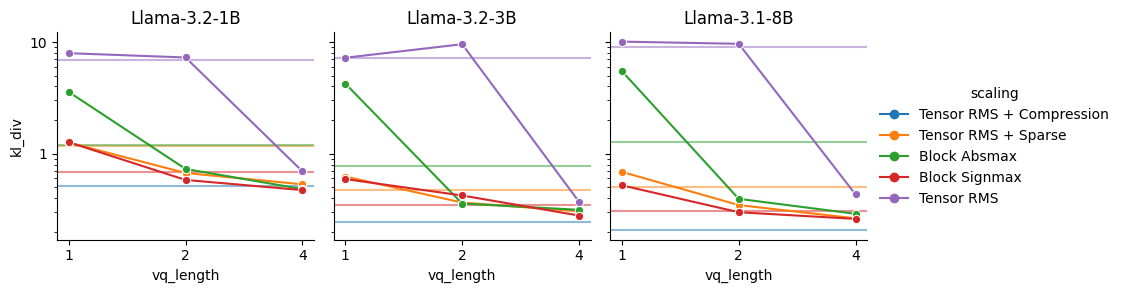

In [112]:
scaling_order = [
    'Tensor RMS + Compression',
    'Tensor RMS + Sparse',
    'Block Absmax',
    'Block Signmax',
    'Tensor RMS',
]
d = df[(df.model.isin(["Llama-3.1-8B", "Llama-3.2-3B", "Llama-3.2-1B"])) & (~df.rotation)].fillna(dict(vq_length=1))

g = sns.relplot(
    data=d[(d.element_family != "t") & (d.scaling != "Tensor RMS + Compression")],
    y="kl_div", x="vq_length", hue="scaling", hue_order=scaling_order,
    marker="o", kind="line", col="model", height=3)
for model, ax in g.axes_dict.items():
    ax.set_title(model)
    ax.set_yscale("log")
    ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter("{x:.0f}")
    ax.yaxis.set_major_formatter("{x:.0f}")
    for hue, scaling in zip(sns.color_palette(), scaling_order):
        # ax.axhline(d[(d.model == model) & (d.scaling == scaling)])
        ax.axhline(d[(d.model == model) & (d.scaling == scaling) & (d.vq_length == 1)].kl_div.min(), color=hue, alpha=.5, zorder=-1)

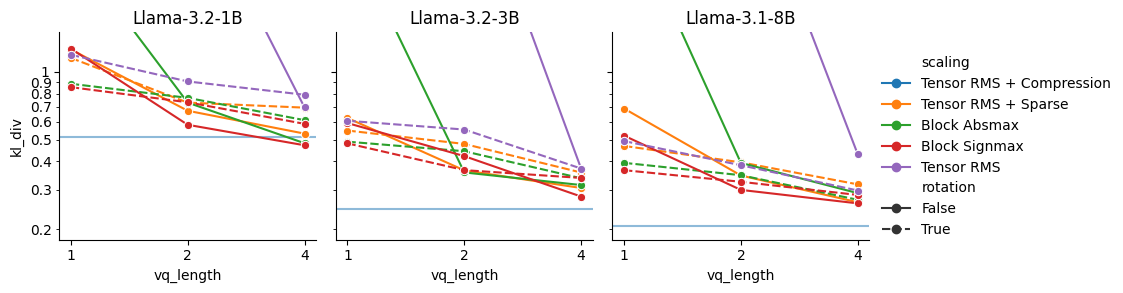

In [111]:
d = df[(df.model.isin(["Llama-3.1-8B", "Llama-3.2-3B", "Llama-3.2-1B"])) & (df.element_family != "t")].fillna(dict(vq_length=1))

g = sns.relplot(
    data=d[(d.scaling != "Tensor RMS + Compression")],
    y="kl_div", x="vq_length", hue="scaling", hue_order=scaling_order, style="rotation",
    marker="o", kind="line", col="model", height=3)
for model, ax in g.axes_dict.items():
    ax.set_title(model)
    ax.set_yscale("log")
    ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter("{x:.0f}")
    ax.yaxis.set_major_formatter("{x:.0f}")
    ax.yaxis.set_minor_formatter("{x:.1f}")
    ax.axhline(d[(d.model == model) & (d.scaling == "Tensor RMS + Compression") & (d.vq_length == 1)].kl_div.min(), color=sns.color_palette()[0], ls="-", zorder=-1, alpha=.5)
    ax.set_ylim((0.18, 1.5))

In [119]:
(df[(df.model == "Llama-3.1-8B") & (~df.rotation)]
 .drop(columns=["model", "rotation"])
 .drop(columns=["fmt"])
 .sort_values("kl_div")
 )

,scaling,element_family,vq_length,bits_per_param,kl_div
84,Tensor RMS + Compression,int,NaN,3.000367,0.206721
22,Block Signmax,lloyd_max,4.0,3.257800,0.260657
23,Tensor RMS + Sparse,lloyd_max,4.0,3.054683,0.263678
21,Block Absmax,lloyd_max,4.0,3.257800,0.289415
18,Block Signmax,lloyd_max,2.0,3.250480,0.299134
88,Block Signmax,t,NaN,3.250423,0.304966
19,Tensor RMS + Sparse,lloyd_max,2.0,3.047363,0.346648
17,Block Absmax,lloyd_max,2.0,3.250480,0.394300
20,Tensor RMS,lloyd_max,4.0,3.007809,0.431194
89,Tensor RMS + Sparse,t,NaN,3.047305,0.503222


In [ ]:
# for id in df[df.vq_length.isna()].sort_values("model").id:
#     E.delete_run(id)